In [1]:
# Public data from Uruguay: Transit fines
# https://catalogodatos.gub.uy/dataset/multas-transito/resource/3a927dca-1744-4ec0-9787-647b4669e4aa?inner_span=True

# Files: 
# multasYYYY.csv        : information of fines
# ordenanza.csv         : orders (type of fine)
# tipos_de_vehiculo.csv : mapping of type of vehicle


# Clean data
# ----------
# Replace NA values by ''
# Join all the fine files in one dataFrame
# Add column year: extracted from file name
# Format date
# add column hour

# Functions
# ---------
# Process and clean data: process_data_fine, process_data_order, process_cartype, process_data
# One function for each question

# Questions
# ---------
# Does the season affects infractions?
# Does the hour affects infractions?
# Does the day of the week affects infractions?
# Does the location affects infractions?
# Does the type of car affects infractions?
# What is the correlation between the hour and the location?
# What is the relation between the day and the hour?


In [2]:
import os
import re
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

COLUMNS_CSV=['Order','Article','Section','Date','Street','Corner','CarType']
COLUMNS=['Order','Article','Section','Date','Street','Corner','CarType', 'Year']
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

In [3]:
#show original data
data_fines = pd.read_csv("multas2006.csv", sep=',', header = None, low_memory=False)
data_fines.head()

,0,1,2,3,4,5,6
0,Ordenanza,Articulo,Apartado,Fecha,Calle,Calle_esquina,Tipo_vehiculo
1,1,140,BM,01/01/2006 01:59,4956,6135,65
2,8,23,1,01/01/2006 09:49,4956,6315,
3,1,8,1,01/01/2006 10:20,4956,6315,62
4,8,23,1,01/01/2006 16:03,5973,6600,


In [4]:
data_orders = pd.read_csv("ordenanza.csv", sep=',', header = None, low_memory=False)
data_orders.head()

,0,1,2,3,4,5
0,orde_id,articulo,apartado,descripcion,importe,fecha_baja
1,1,2,NaN,DESOBEDIENCIA A LAS DISPOSICIONES (D.539),1.4841,NaN
2,1,3,NaN,DESOBEDIENCIA A SEÑALIZACIÓN (D.540),1.4841,NaN
3,1,4,B,VEHÍCULO CIRCULANDO POR LA ACERA (D.541),4,NaN
4,1,5,A,VEHÍCULOS: USO INDEBIDO DE LAS ACERAS NO DAR P...,4,NaN


In [5]:
data_cars = pd.read_csv("tipos_de_vehiculo.csv", sep=',', header = None, low_memory=False)
data_cars.head()

,0,1
0,Código,Nombre
1,1,SEDAN
2,2,SEDAN 2 PUERTAS
3,3,SEDAN 4 PUERTAS
4,4,CONVERTIBLE


In [3]:
#auxiliar functions to clear and process the data

def process_data_fine(file, year):
    car_fines = pd.read_csv(file, sep=',', header = None, low_memory=False) #read csv file
    car_fines.columns=COLUMNS_CSV  #set column names
    car_fines = car_fines.assign(Year=year) #add year column
    car_fines = car_fines.drop(0)  #drop the first column, it is the header
    #modify columns, add NaN if the value is empty
    car_fines['Order']= np.where(car_fines['Order'].str.strip()=='',np.nan, car_fines['Order'])
    car_fines['Article']= np.where(car_fines['Article'].str.strip()=='',np.nan, car_fines['Article'])
    car_fines['Section']= np.where(car_fines['Section'].str.strip()=='.', np.nan, car_fines['Section'])
    car_fines['Date'] = pd.to_datetime(car_fines['Date'])
    car_fines['Hour'] = car_fines['Date'].dt.hour
    car_fines['Corner']= np.where(car_fines['Corner'].str.strip()=='',np.nan, car_fines['Corner'])
    car_fines['CarType']= np.where(car_fines['CarType'].str.strip()=='',np.nan, car_fines['CarType'])
    return car_fines

#process the information of orders
def process_data_order(file): 
    orders = pd.read_csv(file, sep=',', header = None, low_memory=False) #read csv file
    orders = orders.drop(5, axis=1)
    orders.columns = ["order_id","article","section","description","price"]
    orders=orders.drop(0)
    
    orders['price'] = orders['price'].apply(float)
    return orders

#process car type information
def process_cartype(file):
    car_types = pd.read_csv(file, sep=',', header = None, low_memory=False) #read csv file
    car_types.columns = ["code","name"]
    car_types = car_types.drop(0) #delete first column, it is the header
    return car_types


def process_data():
    # for each file, add data to dataframe df
    # the year is in the name of the file
    df = pd.DataFrame(columns=COLUMNS)
    files = os.listdir()
    for file in files:
        prog = re.compile('multas(\d{4}).csv')
        result = prog.match(file)
        if (result): # it is multasYYYY.csv 
            year = int(result.group(1))
            file_data = process_data_fine(file,year)
            df = pd.concat([df, file_data], sort=False, ignore_index=True) #add data frame to df
        elif (file=='ordenanza.csv'):
            orders=process_data_order(file)
        elif (file=='tipos_de_vehiculo.csv'):
            car_types=process_cartype(file)
    
    return (df, orders, car_types)


In [4]:
# clear and process data
(df, orders, car_types) = process_data()
df.head(3)

,Order,Article,Section,Date,Street,Corner,CarType,Year,Hour
0,1,110,A,2009-01-01 14:45:00,4467,7572,NaN,2009,14.0
1,1,106,NaN,2009-01-01 15:40:00,1010,2562,3,2009,15.0
2,1,103,2,2009-02-01 08:40:00,957,3936,13,2009,8.0


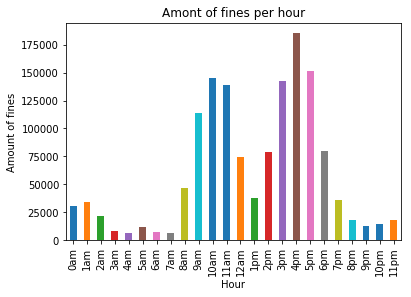

In [8]:
#Does the hour affects infractions?
def amount_fines_per_hour(df):
    data_by_hour = df[['Hour']].copy()
    data_by_hour = data_by_hour.groupby('Hour').size()
    return data_by_hour

fines_per_hour = amount_fines_per_hour(df)
fines_per_hour
plt.figure()
fines_per_hour.plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Amount of fines')
plt.title('Amont of fines per hour')
plt.xticks(range(24), ['0am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12am',
           '1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'])
plt.show()
# We can see that around 5pm there are more fines. (Rush hour)

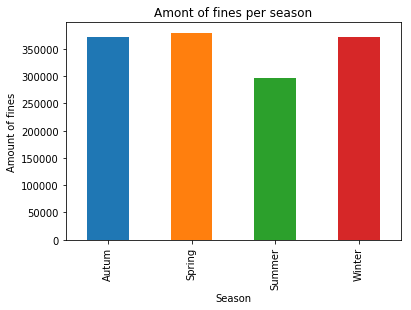

In [9]:
#Does the season affects infractions?
def mapping_month_season(month):
    if (month in [12,1,2]):
        return 'Summer'
    elif (month in [3,4,5]):
        return 'Autum'
    elif (month in [6,7,8]):
        return 'Winter'
    else:
        return 'Spring'
    

# mapping seasons
# spring begins on 1 September
# summer on 1 December
# autumn on 1 March
# winter on 1 June.
def amount_fines_per_season(df):
    data_by_month = df[['Date']].copy()
    data_by_month['Date'] = pd.to_datetime(data_by_month['Date']).dt.month
    data_by_month['Date'] = data_by_month['Date'].apply(mapping_month_season)
    data_by_month = data_by_month.groupby('Date')
    data_by_month = data_by_month.size()
    return data_by_month

fines_per_season = amount_fines_per_season(df)
plt.figure()
fines_per_season.plot(kind='bar')
plt.xlabel('Season')
plt.ylabel('Amount of fines')
plt.title('Amont of fines per season')
plt.show()
# We can see that during the summer there are less fines. 
# It might becase the people do not stay at the city. So there are less people, less fines.

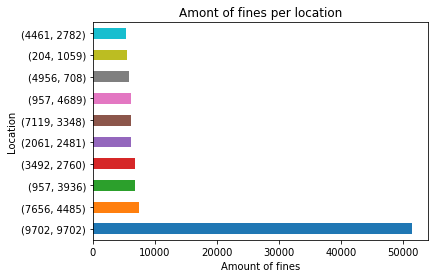

In [10]:
#Does the location affects infractions?
def amount_fines_by_location(df):
    street_corner = df[['Street', 'Corner']].copy()
    street_corner = street_corner.groupby(['Street', 'Corner']).size()
    return street_corner

fines_by_location = amount_fines_by_location(df)
location_10 = fines_by_location.nlargest(10)
plt.figure()
location_10.plot(kind='barh')
plt.ylabel('Location')
plt.xlabel('Amount of fines')
plt.title('Amont of fines per location')
plt.show()
#We see that most of the fines are at one location, there might be a problem there

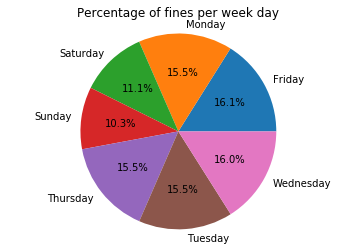

In [11]:
#Does the day of the week affects infractions?
def amount_fines_per_day_week(df):
    data_day = df[['Date']].copy()
    data_day['Day'] = pd.to_datetime(data_day['Date']).dt.dayofweek.map(dayOfWeek)
    data_day = data_day.groupby(['Day']).size()
    return data_day 

fines_per_day_week = amount_fines_per_day_week(df)
fig1, ax1 = plt.subplots()
ax1.pie(fines_per_day_week, labels = list(fines_per_day_week.index), autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Percentage of fines per week day')
plt.show()
#It is almost the same percentage for each day

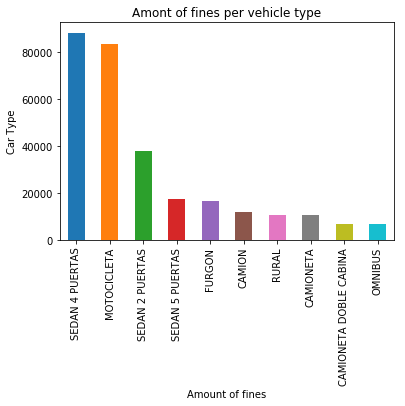

In [12]:
#Does the type of vehicle affects infractions?
def amount_fines_by_car_type(df, car_types):
    car_type_data = df[['CarType']].copy()
    join_data = car_type_data.set_index('CarType').join(car_types.set_index('code'))
    join_data = join_data.groupby(['name']).size()
    return join_data

fines_by_car_type = amount_fines_by_car_type(df, car_types)
fines_by_car_type_10 = fines_by_car_type.nlargest(10)
plt.figure()
fines_by_car_type_10.plot(kind='bar')
plt.ylabel('Car Type')
plt.xlabel('Amount of fines')
plt.title('Amont of fines per vehicle type')
plt.show()

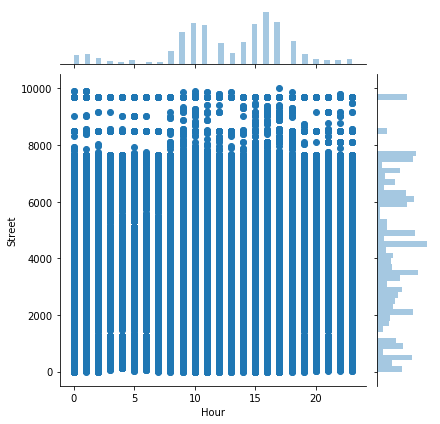

-0.021057410312145444


In [13]:
#What is the correlation between the hour and the location?
df['Street'] = df['Street'].apply(int)
sns.jointplot(x='Hour',y='Street',data=df)
plt.show()
print(df['Hour'].corr(df['Street']))
#From the greaph I can conclude that there is no correlation between the two variables, or it is very low

In [5]:
#What is the relation between the day and the hour?
df['Day'] = pd.to_datetime(df['Date']).dt.dayofweek.map(dayOfWeek)

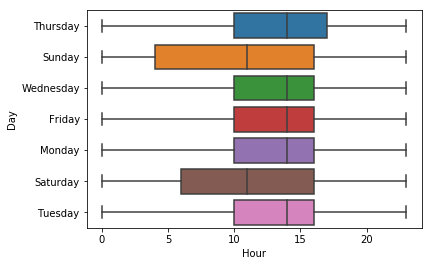

In [6]:
sns.boxplot(y='Day', x='Hour',data=df, whis='range')
#During sunday varies more
#maybe because during the weekend is out of the rutine